In [ ]:
# Libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from tqdm import tqdm
import pdb

seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
torch.cuda.manual_seed_all(seed)

NameError: name 'random' is not defined

In [ ]:
# Other globals
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

--2024-03-12 04:45:57--  http://cseweb.ucsd.edu/~viscomp/projects/LF/papers/ECCV20/nerf/tiny_nerf_data.npz
Resolving cseweb.ucsd.edu (cseweb.ucsd.edu)... 132.239.8.30
Connecting to cseweb.ucsd.edu (cseweb.ucsd.edu)|132.239.8.30|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cseweb.ucsd.edu//~viscomp/projects/LF/papers/ECCV20/nerf/tiny_nerf_data.npz [following]
--2024-03-12 04:45:58--  https://cseweb.ucsd.edu//~viscomp/projects/LF/papers/ECCV20/nerf/tiny_nerf_data.npz
Connecting to cseweb.ucsd.edu (cseweb.ucsd.edu)|132.239.8.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12727482 (12M)
Saving to: ‘tiny_nerf_data.npz’

tiny_nerf_data.npz  100%[===================>]  12.14M  6.69MB/s    in 1.8s    

2024-03-12 04:46:00 (6.69 MB/s) - ‘tiny_nerf_data.npz’ saved [12727482/12727482]



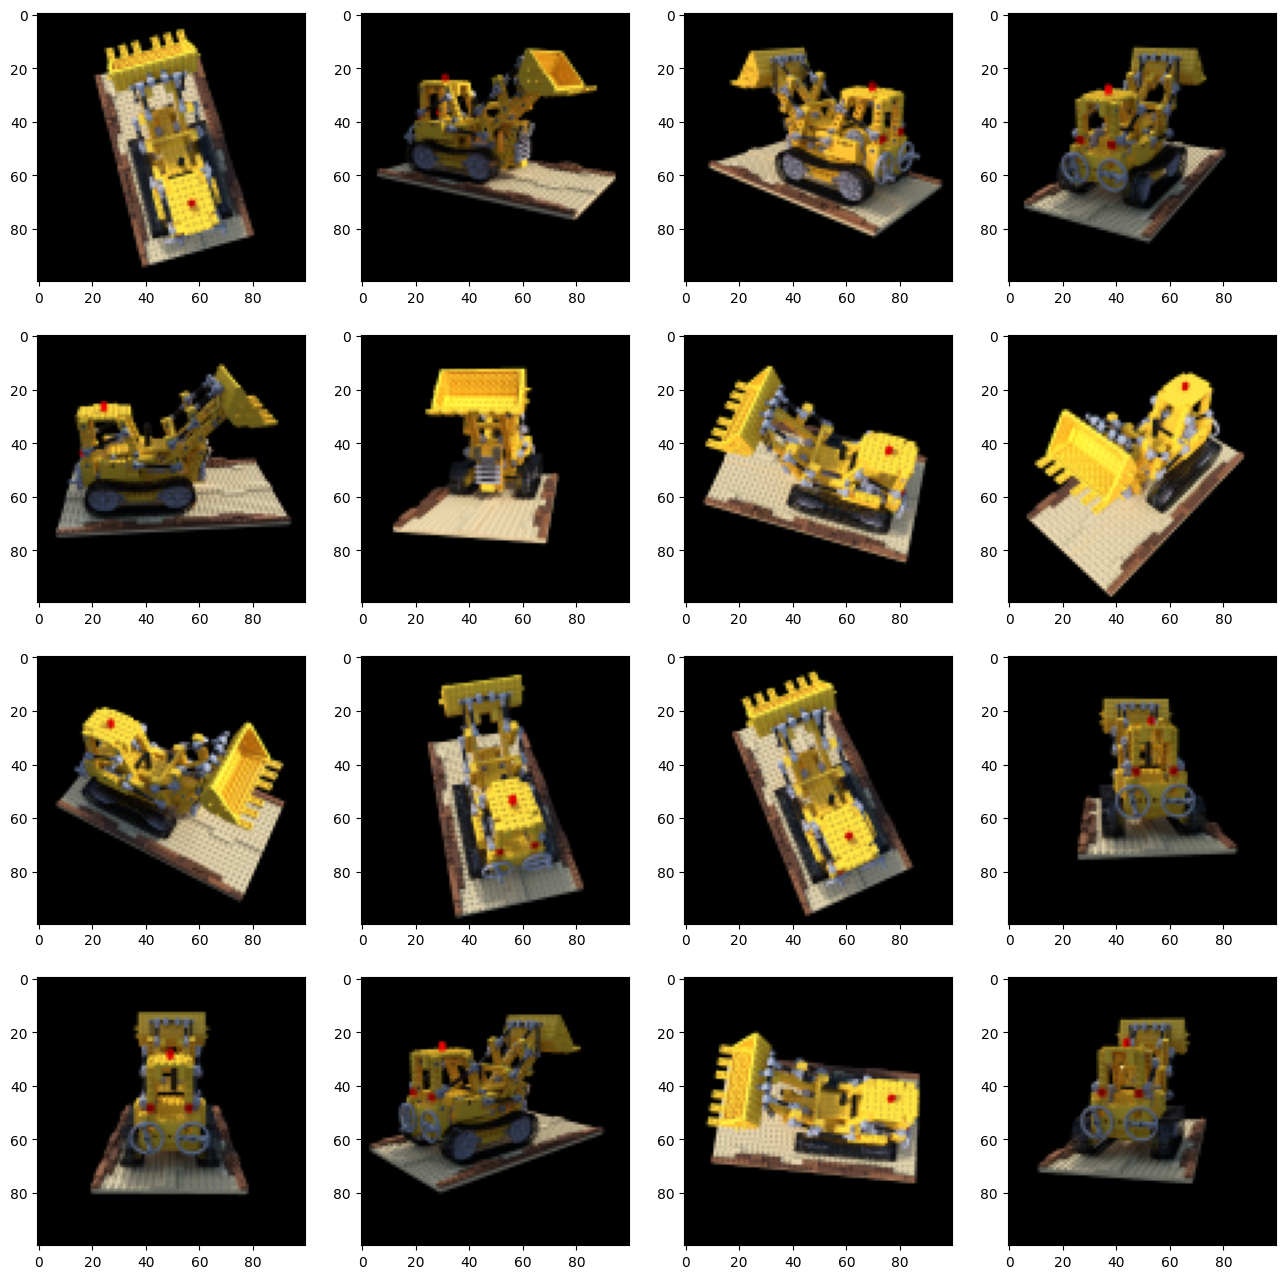

In [ ]:
# Load dataset
if not os.path.exists('tiny_nerf_data.npz'):
  !wget http://cseweb.ucsd.edu/~viscomp/projects/LF/papers/ECCV20/nerf/tiny_nerf_data.npz
data = np.load('tiny_nerf_data.npz')

# Visualize images in dataset
num_images = data['images'].shape[0]
random_indices = np.random.choice(num_images, size=16, replace=False)
fig = plt.figure(figsize=(16,16))
for i in range(1, len(random_indices)+1):
  fig.add_subplot(4,4,i)
  plt.imshow(data["images"][random_indices[i-1]])

In [ ]:
# Convert data to tensors

# Hold one image for test
images = data['images']
test_image = images[101]
test_image = torch.from_numpy(test_image).to(device)
images = torch.from_numpy(images[:100,]).to(device)

poses = data['poses']
poses = torch.from_numpy(poses).to(device)
test_pose = poses[101]

focal_length = data['focal']
focal_length = torch.from_numpy(focal_length).to(device)

height, width = images.shape[1:3] # TODO: isn't it width, height?

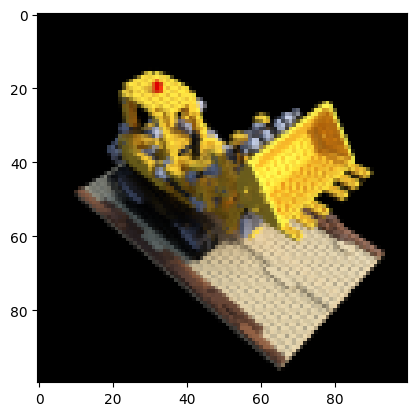

In [ ]:
# Visualize test image
plt.imshow(test_image.detach().cpu().numpy())

In [ ]:
# Compute directions and origins for rays for all pixels in the image.
# Both will be of shape  h x w x 3
def get_raybundle_for_img(height: int, width: int, focal_length: float, tf_cam2world: torch.Tensor):

  # Create a meshgrid for the image pixels
  pixel_coors_along_w = torch.arange(width)
  pixel_coors_along_h = torch.arange(height)
  wcoor_grid_pixel = pixel_coors_along_w.expand(height,-1).to(device)
  hcoor_grid_pixel = pixel_coors_along_h.view(-1,1).expand(-1, width).to(device)

  # Compute ray directions extending from optical center to 3d world for every pixel.
  # This is basically expressing pixel coordinates in world frame.
  wcoor_grid_cam = (wcoor_grid_pixel - (width/2))/ focal_length
  hcoor_grid_cam = -1*(hcoor_grid_pixel - (height/2))/ focal_length
  pixel_coors_cam = torch.stack([wcoor_grid_cam, hcoor_grid_cam, -torch.ones_like(wcoor_grid_cam)], dim=-1)

  # To convert cam to world frame, 3x3 rotation matrix of pose must be multiplied by column vector of each point.
  # We have hxwx3 matrix. Write down the multiplication for one element and you'll know how to implement it.
  pixel_coors_world = torch.sum(pixel_coors_cam[..., None, :] * tf_cam2world[:3, :3], dim=-1)
  ray_directions_world = pixel_coors_world

  ray_origins_world = tf_cam2world[:3,-1].expand(pixel_coors_world.shape)

  return ray_origins_world, ray_directions_world

In [ ]:
# Converts world coordinates to Normalized Device coordinates so that in forward-facing captures the scene can be bounded.
# In world space, you will sample depth values between n and f, where f=infinity in forward-facing scenes.
# In ndc space, you will instead sample depth values between n and 1. After shifting origin to near plane, you can sample depth values between 0 and 1.
def tf_world2ndc(ray_origins_world, ray_directions_world, near, width, height, focal_length):
  # Shift ray origins to near plane
  depths = -(near + ray_origins_world[..., 2])/ ray_directions_world[..., 2]
  ray_origins_world = ray_origins_world + depths[..., None] * ray_directions_world # TODO- check why None

  # Project from world to ndc space
  o_x = (-focal_length * ray_origins_world[...,0]) / ((width/2.)*ray_origins_world[...,2])
  o_y = (-focal_length * ray_origins_world[...,1]) / ((height/2.)*ray_origins_world[...,2])
  o_z = ((2.0*focal_length) + ray_origins_world[...,2]) / (ray_origins_world[...,2])
  d_x = (-focal_length / (width/2.0)) * ((ray_directions_world[...,0]/ray_directions_world[...,2])-(ray_origins_world[...,0]/ray_origins_world[...,2]))
  d_y = (-focal_length / (height/2.0)) * ((ray_directions_world[...,1]/ray_directions_world[...,2])-(ray_origins_world[...,1]/ray_origins_world[...,2]))
  d_z = (-2.0 * focal_length) / (ray_origins_world[...,2])

  ray_origins_ndc = torch.stack([o_x, o_y, o_z], -1)
  ray_directions_ndc = torch.stack([d_x, d_y, d_z], -1)
  return ray_origins_ndc, ray_directions_ndc

In [ ]:
# Do inverse tranform sampling- https://en.wikipedia.org/wiki/Inverse_transform_sampling
def sample_pdf(bins, weights, num_samples, sample_randomly):

  # Calculate PDF. Divide by sum to get them between 0 and 1.
  weights = weights + 1e-5
  pdf = weights/weights.sum(-1).unsqueeze(-1)

  # Compute CDF for all bins starting from 0 to 1
  cdf = torch.cumsum(pdf, dim=-1)
  cdf = torch.cat((torch.zeros_like(cdf[...,:1]), cdf), dim=-1)

  # Generate samples from standard uniform distribution deterministically or randomly
  if sample_randomly:
    samples_uniform = torch.rand(list(cdf.shape[:-1])+[num_samples]).to(weights)
  else:
    samples_uniform = torch.linspace(0., 1., num_samples).to(weights)
    samples_uniform = samples_uniform.expand(list(cdf.shape[:-1])+[num_samples])

  # Find indices where cdf value is just above the sampled value
  indices = torch.searchsorted(cdf, samples_uniform, side='right')

  # Ensure they are within the range of possible indices and find the indices that are right below and above these
  below_indices = torch.max(torch.zeros_like(indices-1), indices-1)
  above_indices = torch.min((cdf.shape[-1]-1) * torch.ones_like(indices) , indices)

  # Find the respective cdf values and the bin values
  cdf_for_below_indices = torch.gather(cdf, -1, below_indices)
  bin_for_below_indices = torch.gather(bins, -1, below_indices)
  cdf_for_above_indices = torch.gather(cdf, -1, above_indices)
  bin_for_above_indices = torch.gather(bins, -1, above_indices)

  # Find denom and ensure numerical stability during division
  denom = cdf_for_above_indices - cdf_for_below_indices
  denom = torch.where(denom<1e-5, torch.ones_like(denom), denom)

  # Find interpolation weights
  # If sample_uniform is close to below index, then interpolation weight will be close to 0.
  interpolation_weights = (samples_uniform - cdf_for_below_indices)/denom

  # Perform linear interpolation
  # if interpolation weight = 0, then below will be chosen.
  # if interpolation weight = 1, then above bin will be chosen.
  # if interpolation weight is between 0 and 1, linear interpolation.
  samples_cdf = bin_for_below_indices + (interpolation_weights * (bin_for_above_indices-bin_for_below_indices))

  return samples_cdf




In [ ]:
# Sample 3D points and their depth values on the ray bundle
# sampled 3d points will be of shape h x w x num_samples x 3 and depth_values will be of shape h x w x num_samples
# TODO: t_values vs depth_values?
def sample_coarse_points(ray_directions: torch.Tensor, ray_origins: torch.Tensor, nearThresh: float, farThresh: float, num_points: int, linear_disparity):
  t_values = torch.linspace(0., 1., num_points).to(device) # (num_points)
  if linear_disparity:
    z_values = 1. / (1. / nearThresh * (1. - t_values) + 1. / farThresh * t_values)
  else:
    z_values = nearThresh * (1. - t_values) + farThresh * t_values
  z_values = z_values.expand([ray_directions.shape[0], num_points])

  # Randomize depth values
  mids = 0.5 * (z_values[..., 1:] + z_values[..., :-1])
  upper = torch.cat((mids, z_values[..., -1:]), dim=-1)
  lower = torch.cat((z_values[..., :1], mids), dim=-1)
  t_rand = torch.rand(z_values.shape).to(device)
  depth_values = lower + (upper - lower) * t_rand

  sample_points = ray_origins[...,None,:] + (ray_directions[...,None,:] * depth_values[...,:,None])
  return depth_values, sample_points

In [ ]:
# Perform positional encoding on a tensor to get a high-dimensional representation enabling better capture of high frequency variations and
# to capture the relationship between tensor values.
# encoding is of shape (h * w * num_samples, 3 +(2 * num_encoding_functions * 3))
def positional_encoding(tensor: torch.Tensor, num_encoding_functions: int, include_input: bool):
  if include_input:
    encoding = [tensor] # (h * w * num_samples, 3)
  else:
    encoding = []

  frequency_band = torch.linspace(
        2.0 ** 0.0,
        2.0 ** (num_encoding_functions - 1),
        num_encoding_functions,
        dtype=tensor.dtype,
        device=tensor.device,
  )
  for frequency in frequency_band:
    for func in [torch.sin, torch.cos]:
      sinusoidal_component = func(tensor * frequency)
      encoding.append(sinusoidal_component)

  return torch.cat(encoding, dim=-1)

In [ ]:
# Define model architecture.
# Input is of shape - (h * w * num_samples, (2 * num_posencoding_functions * 3)+(2 * num_direncoding_functions * 3))
# Output is of shape - (h * w * num_samples, 4) where the 4-dim vector represents the RGB information and density of that respective 3D sample point.
class NeRF(nn.Module):

  def __init__(self, num_encoding_pos, num_encoding_dir, use_viewdirs):
    super(NeRF, self).__init__()
    self.num_layers = 5
    self.skip_layer = 4
    self.filter_size = 128
    self.output_size = 4
    self.use_viewdirs = use_viewdirs
    self.input_pos_dim = 2 * num_encoding_pos * 3
    self.input_dir_dim = 2 * num_encoding_dir * 3

    self.fc_layers = nn.ModuleList()
    self.fc_layers.append(nn.Linear(self.input_pos_dim, self.filter_size))
    for layer in range(self.num_layers-1):
      # Skip - Adding residual connection
      if layer == self.skip_layer-1:
        self.fc_layers.append(nn.Linear(self.input_pos_dim + self.filter_size, self.filter_size))
      else:
        self.fc_layers.append(nn.Linear(self.filter_size, self.filter_size))

    if self.use_viewdirs:
      self.alpha_layer = nn.Linear(self.filter_size, 1)

      self.fc_dir1_layer = nn.Linear(self.filter_size, self.filter_size)
      self.fc_dir2_layer = nn.Linear(self.input_dir_dim + self.filter_size, self.filter_size//2)
      # self.rgb_layer = nn.Linear(filter_size//2, filter_size//2)
      self.rgb_layer = nn.Linear(self.filter_size//2, self.output_size-1)
    else:
      self.out_layer = nn.Linear(self.filter_size, self.output_size)

  def forward(self, x):
    # TODO: isn't input 6D? why are they saying 5D?
    input_pos, input_dir = x[...,:self.input_pos_dim], x[..., self.input_pos_dim:]
    x = input_pos
    for i, layer in enumerate(self.fc_layers):
      # print(i, layer)
      if i == self.skip_layer:
        # print(x.shape, input_pos.shape)
        x = self.fc_layers[i](torch.cat((input_pos, x), dim=-1))
      else:
        x = self.fc_layers[i](x)
      x = nn.functional.relu(x)

    if self.use_viewdirs:
      alpha = self.alpha_layer(x)
      feature = self.fc_dir1_layer(x)
      x = self.fc_dir2_layer(torch.cat((input_dir, feature), dim=-1))
      x = nn.functional.relu(x) # TODO: Isn't this sigmoid in paper
      rgb = self.rgb_layer(x)
      x = torch.cat((rgb, alpha), dim=-1)
    else:
      x = self.out_layer(x)

    return x

In [ ]:
NeRF(6,6,True)

NeRF(
  (fc_layers): ModuleList(
    (0): Linear(in_features=36, out_features=128, bias=True)
    (1-3): 3 x Linear(in_features=128, out_features=128, bias=True)
    (4): Linear(in_features=164, out_features=128, bias=True)
  )
  (alpha_layer): Linear(in_features=128, out_features=1, bias=True)
  (fc_dir1_layer): Linear(in_features=128, out_features=128, bias=True)
  (fc_dir2_layer): Linear(in_features=164, out_features=64, bias=True)
  (rgb_layer): Linear(in_features=64, out_features=3, bias=True)
)

In [ ]:
# Input is of shape (chunk_size x num_samples x 4)
# Output is of shape (chunk_size x 3)
# TODO: Add diagramatic explanation for understanding
def render_image_batch_from_3dinfo(rgb_density: torch.Tensor, depth_values: torch.Tensor, use_white_bkgd: bool):

  # Normalize RGB values to the range 0 to 1 and since density (opacity/ amount of light absorbed/ absorption coeff) is non-negative, apply relu activation.
  rgb_values = torch.sigmoid(rgb_density[..., :3]) # (chunk_size x num_samples x 3)
  density_values = torch.nn.functional.relu(rgb_density[..., 3])

  # print(rgb_values.shape, density_values.shape)

  # Compute consecutive difference between depth values, i.e distance of every segment sampled in 3D space
  dist_values = depth_values[...,1:]-depth_values[...,:-1]

  # For the last segment i.e between the last sampled point and ray end, distance is unbounded. So to make it tractable, we add last segment distance to a large value.
  one_e10 = torch.tensor([1e10], dtype=depth_values.dtype, device=depth_values.device).expand(depth_values[..., :1].shape)
  dist_values = torch.cat([dist_values, one_e10], dim=-1) # (h x w x num_samples)
  # print(dist_values.shape)
  # Compute cumulative transmittance along every segment (complement of absorption, i.e amount of light trasmitted through medium after absorption)
  transmittance_values = 1. - torch.exp(-density_values * dist_values)
  num_stability_val = 1e-10
  cum_transmittance_values = transmittance_values * cumprod_exclusive(1. - transmittance_values + num_stability_val) # (h x w x num_samples)
  # TODO: why 1-transmittance values

  # Render RGB map i.e RGB image
  rgb_map = (cum_transmittance_values[..., None] * rgb_values).sum(dim=-2) # (h x w x 3)

  # Render depth map i.e. depth image
  depth_map = (cum_transmittance_values * depth_values).sum(dim=-1) # (h x w x 1)

  # Compute cum trasnmittance for image
  accumulated_transmittance_map = cum_transmittance_values.sum(dim=-1)

  # White background
  if use_white_bkgd:
    rgb_map = rgb_map + (1. - accumulated_transmittance_map[...,None])

  # Disparity Map
  disp_map = 1./torch.max(1e-10 * torch.ones_like(depth_map), depth_map / accumulated_transmittance_map)

  return rgb_map, disp_map, accumulated_transmittance_map, depth_map, cum_transmittance_values



In [ ]:
def cumprod_exclusive(tensor: torch.Tensor):

  # for input (a,b,c), cumprod_inclusive is (a, a*b, a*b*c)
  cumprod_inclusive = torch.cumprod(tensor, dim=-1)

  # for input (a,b,c), cumprod_exclusive is (1, a, a*b)
  cumprod_exclusive = torch.roll(cumprod_inclusive, 1, dims=-1) # (a*b*c, a, a*b)
  cumprod_exclusive[..., 0] = 1.

  return cumprod_exclusive

In [ ]:
def get_chunks(tensor: torch.Tensor, chunk_size: int):
  chunks = [tensor[i:i+chunk_size] for i in range(0, tensor.shape[0], chunk_size)]
  return chunks

In [ ]:
def get_radiance_field_per_chunk(sample_points, model, num_pos_encoding_functions, include_input_in_posenc, use_viewdirs,
								 viewdirs_batch, num_dir_encoding_functions, include_input_in_direnc, chunk_size):

		# Flatten sample points
		flattened_sample_points = sample_points.view(-1,3) # h*w*num, 3

		# Encode sample points using positional embedding
		encoded_sample_points = positional_encoding(flattened_sample_points, num_pos_encoding_functions, include_input_in_posenc)
		if use_viewdirs:
				ipdirs_batch = viewdirs_batch[...,None,:].expand(sample_points.shape) # h*w,num,3
				ipdirs_batch = ipdirs_batch.reshape(-1, 3) # h*w*num, 3
				encoded_dirs = positional_encoding(ipdirs_batch, num_dir_encoding_functions, include_input_in_direnc)
				encoded_sample_points_batch = torch.cat((encoded_sample_points, encoded_dirs), dim=-1)

		# Batchify
		ip_chunks = get_chunks(encoded_sample_points_batch, chunk_size)
		rgba_batch = []
		for chunk in ip_chunks:
			rgba_batch.append(model(chunk.to(device)))

		rgba_batch = torch.cat(rgba_batch, dim=0)
		rgba_batch = rgba_batch.reshape(list(sample_points.shape[:-1]) + [rgba_batch.shape[-1]])
		return rgba_batch

In [ ]:
def run_nerf(height, width, focal_length, training_campose, use_viewdirs, is_ndc_required, use_white_bkgd,
             near_thresh, far_thresh, num_coarse_samples_per_ray, num_fine_samples_per_ray,
             include_input_in_posenc, include_input_in_direnc, num_pos_encoding_functions,
             num_dir_encoding_functions, model_coarse, model_fine, chunk_size, num_random_rays, mode):

	if mode == 'train':
		model_fine.train()
		model_coarse.train()
	else:
		model_fine.eval()
		model_coarse.eval()

	ray_origins, ray_directions = get_raybundle_for_img(height, width, focal_length, training_campose)

	if use_viewdirs: # TODO: check benefit of this
		view_dirs = ray_directions / ray_directions.norm(p=2, dim=-1).unsqueeze(-1)
		view_dirs = view_dirs.view(-1, 3)

	if is_ndc_required:
		ray_origins, ray_directions = tf_world2ndc(ray_origins, ray_directions, near_thresh, height, width, focal_length)

	# Flatten and concatenate
	ray_origins = ray_origins.view(-1, 3)
	ray_directions = ray_directions.view(-1, 3) # h*w, 3

	# Randomly sample rays for OOM error
	random_indices = []
	if mode=='train' and num_random_rays > 0:
		random_indices = np.random.choice(ray_directions.shape[0], size=(num_random_rays), replace=False)
		ray_directions = ray_directions[random_indices, :] # num_rand_rays x 3
		ray_origins = ray_origins[random_indices, : ] # num_rand_rays x 3
		if use_viewdirs:
			view_dirs = view_dirs[random_indices, : ]

	near_points = near_thresh * torch.ones_like(ray_directions[...,:1])
	far_points = far_thresh * torch.ones_like(ray_directions[...,:1]) # h*w, 1 or num_random_rays, 1
	concatenated_rays = torch.cat((ray_origins, ray_directions, near_points, far_points), dim=-1)
	if use_viewdirs:
		concatenated_rays = torch.cat((concatenated_rays, view_dirs), dim=-1) # h*w, 11 or or num_random_rays, 11

	# Batchify
	chunks = get_chunks(concatenated_rays, chunk_size)
	rgb_map_coarse_list = []
	rgb_map_fine_list = []
	for chunk in chunks:
		ray_origins_batch, ray_directions_batch = chunk[...,:3], chunk[...,3:6]
		near_points_batch, far_points_batch = chunk[...,6], chunk[...,7]
		if use_viewdirs:
			viewdirs_batch = chunk[..., 8:] # h*w, 3

		# Stratified Sampling for generating coarse points
		coarse_depth_values, coarse_sample_points = sample_coarse_points(ray_directions_batch, ray_origins_batch,
																		near_thresh, far_thresh, num_coarse_samples_per_ray,
																		is_ndc_required)
		rgba_coarse = get_radiance_field_per_chunk(coarse_sample_points, model_coarse, num_pos_encoding_functions,
												include_input_in_posenc, use_viewdirs, viewdirs_batch,
												num_dir_encoding_functions, include_input_in_direnc, chunk_size)
		# TODO: 1. Check extra arguments - white_bckgd, noise
		# TODO: 2. shud we mutiply by ray_directions ?
		rgb_map_coarse, disp_map_coarse, acc_map_coarse, depth_map_coarse, weights = render_image_batch_from_3dinfo(rgba_coarse , coarse_depth_values, use_white_bkgd)
		rgb_map_coarse_list.append(rgb_map_coarse)

		# Fine - Hierachical Sampling
		if num_fine_samples_per_ray > 0:
			# TODO: Check everything from here ??????
			depth_values_mid = .5 * (coarse_depth_values[..., 1:] + coarse_depth_values[..., :-1])
			z_samples = sample_pdf(depth_values_mid, weights[..., 1:-1], num_fine_samples_per_ray, True)
			z_samples = z_samples.detach()

			fine_depth_values, _ = torch.sort(torch.cat((coarse_depth_values, z_samples), dim=-1), dim=-1)
			fine_sample_points = ray_origins_batch[..., None, :] + ray_directions_batch[..., None, :] * fine_depth_values[..., :, None]

			# rgba_fine = get_radiance_field_per_chunk(fine_sample_points, model_fine, num_pos_encoding_functions,
			# 									include_input_in_posenc, use_viewdirs, viewdirs_batch,
			# 									num_dir_encoding_functions, include_input_in_direnc, chunk_size)
			# Flatten fine sample points
			flattened_fine_sample_points = fine_sample_points.view(-1,3) # h*w*num, 3

			# Encode fine sample points using positional embedding
			encoded_fine_sample_points = positional_encoding(flattened_fine_sample_points, num_pos_encoding_functions, include_input_in_posenc)
			# print(encoded_fine_sample_points.shape)
			if use_viewdirs:
				ipdirs_batch = viewdirs_batch[...,None,:].expand(fine_sample_points.shape) # h*w,num,3
				# print(ipdirs_batch.shape)
				ipdirs_batch = ipdirs_batch.reshape(-1, 3) # h*w*num, 3
				# print(ipdirs_batch.shape)
				encoded_dirs = positional_encoding(ipdirs_batch, num_dir_encoding_functions, include_input_in_direnc)
				# print(encoded_coarse_sample_points.shape, encoded_dirs.shape)
				encoded_fine_sample_points_batch = torch.cat((encoded_fine_sample_points, encoded_dirs), dim=-1)

			rgba_fine = model_fine(encoded_fine_sample_points_batch.to(device))

			rgba_fine = rgba_fine.reshape(list(fine_sample_points.shape[:-1]) + [rgba_fine.shape[-1]])

			rgb_map_fine, disp_map_fine, acc_map_fine, depth_map_fine, _ = render_image_batch_from_3dinfo(rgba_fine , fine_depth_values, use_white_bkgd)
			rgb_map_fine_list.append(rgb_map_fine)

	rgb_coarse_image = torch.cat(rgb_map_coarse_list, dim=0)
	rgb_fine_image = torch.cat(rgb_map_fine_list, dim=0)

	return rgb_coarse_image, rgb_fine_image, random_indices


None
> <ipython-input-26-1207e0b5fe6e>(8)<cell line: 8>()
      6 import torch.nn as nn
      7 from tqdm import tqdm
----> 8 from google.colab import debugger
      9 
     10 seed = 42

ipdb> 5
5
ipdb> 6
6
--KeyboardInterrupt--

KeyboardInterrupt: Interrupted by user


  0%|          | 0/1000 [00:00<?, ?it/s]

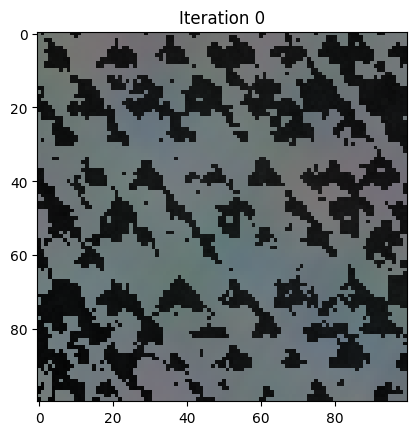

  2%|▏         | 15/1000 [00:06<06:51,  2.39it/s]


KeyboardInterrupt: 

In [ ]:
# Training module
%debug
num_pos_encoding_functions = 6
num_dir_encoding_functions = 6
num_coarse_samples_per_ray = 32
num_fine_samples_per_ray = 32
near_thresh = 2.0 # set based on data
far_thresh = 6.0 # set based on data
include_input_in_posenc = False
include_input_in_direnc = False
is_ndc_required = False # set to True only for forward facing scenes
use_viewdirs = True

num_epochs = 1000
batch_size = 1 # TODO: why not have more images in batch
chunk_size = 4096 # because 4096 for 1.2GB of GPU memory
validate_every = 50
num_random_rays = 0

model_coarse = NeRF(num_pos_encoding_functions, num_dir_encoding_functions, use_viewdirs).to(device)
model_fine = NeRF(num_pos_encoding_functions, num_dir_encoding_functions, use_viewdirs).to(device)
optimizer = torch.optim.Adam(list(model_coarse.parameters()) + list(model_fine.parameters()), lr=5e-3)

for epoch in tqdm(range(num_epochs)):

  # Pick one random sample for training
  index = np.random.randint(len(images)) #TODO: check if it is without replacement
  target_img = images[index].to(device)
  target_img = target_img.reshape(-1, 3)
  training_campose = poses[index].to(device)

  # Call NeRF
  rgb_coarse, rgb_fine, selected_rays_ind = run_nerf(height, width, focal_length, training_campose, use_viewdirs, is_ndc_required, False,
                                  near_thresh, far_thresh, num_coarse_samples_per_ray, num_fine_samples_per_ray,
                                  include_input_in_posenc, include_input_in_direnc, num_pos_encoding_functions,
                                  num_dir_encoding_functions, model_coarse, model_fine, chunk_size, num_random_rays, mode='train')

  if num_random_rays > 0:
    target_img = target_img[selected_rays_ind, :]

  # Compute total loss - coarse + fine
  coarse_loss = torch.nn.functional.mse_loss(rgb_coarse, target_img)
  fine_loss = torch.nn.functional.mse_loss(rgb_fine, target_img)
  total_loss = coarse_loss + fine_loss #TODO - why summing it ?

  # Backpropagate
  optimizer.zero_grad()
  total_loss.backward()
  optimizer.step()

  # Evaluation for every few epochs on test pose
  if epoch % validate_every ==0:
    rgb_test_coarse, rgb_test_fine, _ = run_nerf(height, width, focal_length, test_pose, use_viewdirs, is_ndc_required, False,
                                                 near_thresh, far_thresh, num_coarse_samples_per_ray, num_fine_samples_per_ray,
                                                 include_input_in_posenc, include_input_in_direnc, num_pos_encoding_functions,
                                                 num_dir_encoding_functions, model_coarse, model_fine, chunk_size, num_random_rays, mode='eval')
    fig = plt.figure()
    rgb_test_fine = rgb_test_fine.reshape(height, width, 3)
    plt.imshow(rgb_test_fine.detach().cpu().numpy())
    plt.title(f"Iteration {epoch}")
    plt.show()